In [91]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import os
import sys
import pickle
import json
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM, TaskCDDMplus
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from rnn_coach.src.PerformanceAnalyzer import PerformanceAnalyzerCDDM
from latent_circuit_inference.src.utils import plot_matrix
from scipy.sparse.linalg import lsqr
from copy import deepcopy
from sklearn.decomposition import PCA
import pandas as pd
import datetime
import pickle
from scipy.signal import savgol_filter
from scipy.optimize import minimize
from tqdm.auto import tqdm
from rnn_coach.src.utils import get_colormaps
colors, cmp = get_colormaps()
red, blue, bluish, green, orange, lblue, violet = colors

In [2]:
labels = ["ctx m", "ctx c", "mR inp", "mL inp", "cR inp", "cL inp", "mR", "mL", "cR", "cL", "OutR", "OutL"]
W_inp = np.zeros((12, 6))
W_rec = np.zeros((12, 12))
W_out = np.zeros((2, 12))

W_inp[labels.index("ctx m"), 0] = 1.0
W_inp[labels.index("ctx c"), 1] = 1.0
W_inp[labels.index("mR inp"), 2] = 1.0
W_inp[labels.index("mL inp"), 3] = 1.0
W_inp[labels.index("cR inp"), 4] = 1.0
W_inp[labels.index("cL inp"), 5] = 1.0

W_rec[labels.index("mR"), labels.index("mR inp")] = 1.0
W_rec[labels.index("mL"), labels.index("mL inp")] = 1.0
W_rec[labels.index("cR"), labels.index("cR inp")] = 1.0
W_rec[labels.index("cL"), labels.index("cL inp")] = 1.0

W_rec[labels.index("mR"), labels.index("ctx c")] = -1.2
W_rec[labels.index("mL"), labels.index("ctx c")] = -1.2
W_rec[labels.index("cR"), labels.index("ctx m")] = -1.2
W_rec[labels.index("cL"), labels.index("ctx m")] = -1.2

W_rec[labels.index("OutR"), labels.index("mR")] = 1.1
W_rec[labels.index("OutR"), labels.index("cR")] = 1.1
W_rec[labels.index("OutL"), labels.index("mL")] = 1.1
W_rec[labels.index("OutL"), labels.index("cL")] = 1.1

# W_rec[labels.index("mR"), labels.index("mL")] = -0.4
# W_rec[labels.index("mL"), labels.index("mR")] = -0.4
# W_rec[labels.index("cR"), labels.index("cL")] = -0.4
# W_rec[labels.index("cL"), labels.index("cR")] = -0.4
W_rec[labels.index("mR"), labels.index("cL")] = -0.2
W_rec[labels.index("mR"), labels.index("cR")] = -0.2
W_rec[labels.index("mL"), labels.index("cL")] = -0.2
W_rec[labels.index("mL"), labels.index("cR")] = -0.2
W_rec[labels.index("cR"), labels.index("mL")] = -0.2
W_rec[labels.index("cR"), labels.index("mR")] = -0.2
W_rec[labels.index("cL"), labels.index("mL")] = -0.2
W_rec[labels.index("cL"), labels.index("mR")] = -0.2
W_rec[labels.index("OutL"), labels.index("OutR")] = -0.5
W_rec[labels.index("OutR"), labels.index("OutL")] = -0.5

W_out[0, labels.index("OutR")] = 1.0
W_out[1, labels.index("OutL")] = 1.0

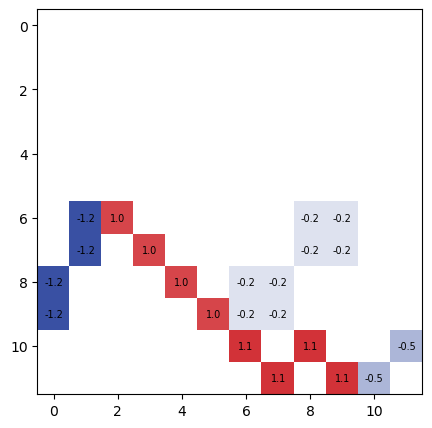

In [8]:
plot_matrix(W_rec, show_numbers=True, vmin = -1.2, vmax = 1.2, figsize = (5,5))

In [32]:
n_steps = 300
input_size = 6
output_size = 2
dt = 1
tau = 10
sigma_rec = 0.03
sigma_inp = 0.03
task_params = {'cue_on': 0,
             'cue_off': n_steps,
             'stim_on': n_steps//3,
             'stim_off': n_steps,
             'dec_on': 2 * n_steps//3,
             'dec_off': n_steps,
             'n_steps': n_steps,
             'n_inputs': input_size,
             'n_outputs': output_size,
             'coherences': [-0.8, -0.4, -0.2, -0.1, 0, 0.1, 0.2, 0.4, 0.8],
             'seed': 0}
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
input_batch, target_batch, conditions_batch = task.get_batch()
mask = np.concatenate([np.arange(n_steps//3), (2 * n_steps//3) + np.arange(n_steps//3)])

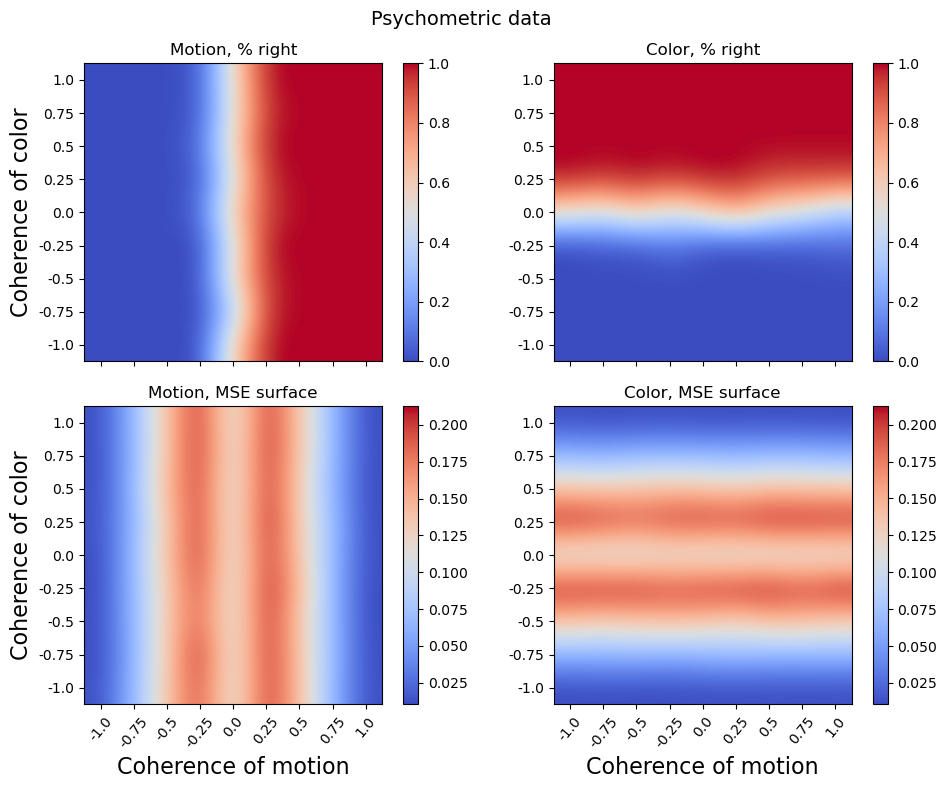

In [36]:
circuit = RNN_numpy(N=W_rec.shape[0], dt=dt, tau=tau, W_inp=W_inp, W_rec = W_rec, W_out=W_out)
pa = PerformanceAnalyzerCDDM(circuit)
pa.calc_psychometric_data(task, mask, num_levels=len(task_params['coherences']), num_repeats=31)
pa.plot_psychometric_data()
plt.show()

In [56]:
circuit.clear_history()
circuit.run(input_timeseries=input_batch, sigma_inp=sigma_inp, sigma_rec=sigma_rec)

In [57]:
y = circuit.get_history()
output = circuit.get_output()

In [59]:
Y = np.hstack([y[:, :, i] for i in range(y.shape[-1])])

In [60]:
T_inp = np.hstack([input_batch[:, :, i] for i in range(input_batch.shape[-1])])
T_out = np.hstack([target_batch[:, :, i] for i in range(target_batch.shape[-1])])
T_out_masked = np.hstack([target_batch[:, mask, i] for i in range(target_batch.shape[-1])])
T_combined = np.vstack([T_inp, T_out])
n_trials = len(conditions_batch)

In [61]:
choice = np.array([conditions_batch[i]['correct_choice'] for i in range(len(conditions_batch))])
motion_coh = np.array([conditions_batch[i]['motion_coh'] for i in range(len(conditions_batch))])
color_coh = np.array([conditions_batch[i]['color_coh'] for i in range(len(conditions_batch))])
context = np.array([(1 if conditions_batch[i]['context']=='motion' else -1) for i in range(len(conditions_batch))])
F = np.hstack([context.reshape(-1, 1),
               motion_coh.reshape(-1, 1),
               color_coh.reshape(-1, 1),
               choice.reshape(-1, 1),
               np.ones((n_trials, 1))])

In [63]:
Z = zscore(Y, axis = 1)
z = Z.reshape(-1, n_trials, n_steps)
z = np.swapaxes(z, 1, 2)

# PCA on Z
pca = PCA(n_components=12)
pca.fit(Z.T)
PCs = pca.components_
D = PCs.T @ PCs
Z_pca = D @ Z
z_pca = Z_pca.reshape(-1, n_trials, n_steps)
z_pca = np.swapaxes(z_pca, 1, 2)

In [65]:
regularization = 0.2
B_tdr = np.zeros((Z.shape[0], n_steps, F.shape[1]))
from sklearn.linear_model import Lasso

for i in tqdm(range(Z.shape[0])):
    for t in range(n_steps):
        betas_i_t = lsqr(F, z_pca[i, t, :], damp=regularization)[0]
        B_tdr[i, t, :] = deepcopy(betas_i_t)
#         reg = Lasso(alpha = regularization).fit(F, z_pca[i, t, :])
#         B_tdr[i, t, :] = deepcopy(reg.coef_)
        
ind_cont = np.argmax(np.linalg.norm(B_tdr[:, :, 0], axis=0, ord=1)[:250])
ind_motion = np.argmax(np.linalg.norm(B_tdr[:, :, 1], axis=0, ord=1))
ind_color = np.argmax(np.linalg.norm(B_tdr[:, :, 2], axis=0, ord=1))
ind_choice = np.argmax(np.linalg.norm(B_tdr[:, :, 3], axis=0, ord=1))

context_direction = B_tdr[:, ind_cont, 0]/np.linalg.norm(B_tdr[:, ind_cont, 0])
motion_direction = B_tdr[:, ind_motion, 1]/np.linalg.norm(B_tdr[:, ind_motion, 1])
color_direction = B_tdr[:, ind_color, 2]/np.linalg.norm(B_tdr[:, ind_color, 2])
choice_direction = B_tdr[:, ind_choice, 3]/np.linalg.norm(B_tdr[:, ind_choice, 3])

B_tdr_max = np.hstack([choice_direction.reshape(-1, 1),
                   motion_direction.reshape(-1, 1),
                   color_direction.reshape(-1, 1),
                   context_direction.reshape(-1,1)])

  0%|          | 0/12 [00:00<?, ?it/s]

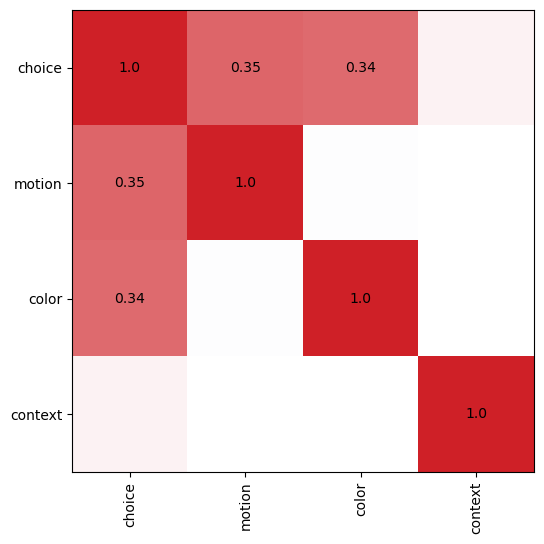

In [93]:
# correlations between the recovered directions
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
mat = B_tdr_max.T @ B_tdr_max
img2 = ax.imshow(mat, cmap=cmp, vmin = -0.5, vmax = 0.5)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z)< 0.03:
        pass
    else:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
ax.set_yticks(np.arange(4), ["choice", "motion", "color", "context"])
ax.set_xticks(np.arange(4), ["choice", "motion", "color", "context"], rotation=90)
plt.show()

In [94]:
# orthogonolizing B_tdr_max
U, S, V = np.linalg.svd(B_tdr_max)

In [95]:
B_orth = U[:, :B_tdr_max.shape[1]] @ V[:B_tdr_max.shape[1], :]

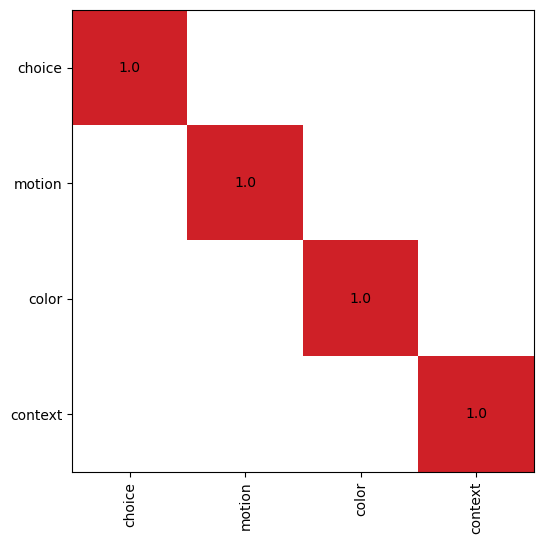

In [97]:
# correlations between the recovered directions
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
mat = B_orth.T @ B_orth
img2 = ax.imshow(mat, cmap=cmp, vmin = -0.5, vmax = 0.5)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z)< 0.03:
        pass
    else:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
ax.set_yticks(np.arange(4), ["choice", "motion", "color", "context"])
ax.set_xticks(np.arange(4), ["choice", "motion", "color", "context"], rotation=90)
plt.show()

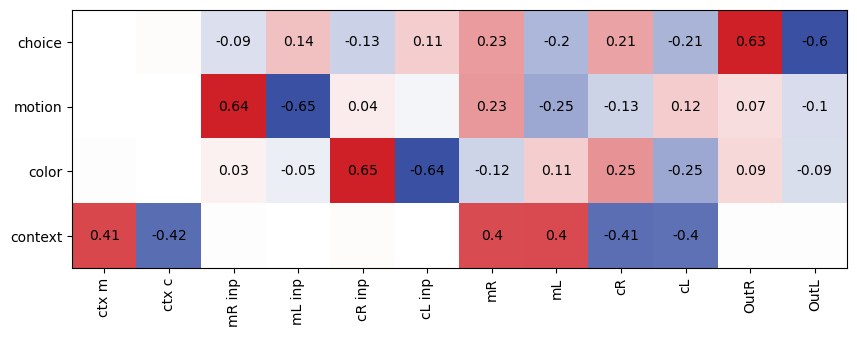

In [96]:
# correlations between the recovered directions
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
mat = B_orth.T
img2 = ax.imshow(mat, cmap=cmp, vmin = -0.5, vmax = 0.5)
for (i, j), z in np.ndenumerate(mat):
    if np.abs(z) < 0.03:
        pass
    else:
        ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
    
ax.set_yticks(np.arange(4), ["choice", "motion", "color", "context"])
ax.set_xticks(np.arange(12), labels, rotation=90)
plt.show()